Note: the dataset contains possible value of 2 if the original piece's left hand and right hand hit that key simultenuously, made adjustment in the train phrase

In [2]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as data
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import random
from torch import optim
import math
import pypianoroll
import Functions as F

# Custom Dataset

note: we compare the loss the final 10 predictions, but I can't, so output seq_len-1 predictions


In [3]:
import os
import pandas as pd
import numpy as np
class customDataset(data.Dataset):
    def __init__(self,path):
        self.path = path
        fnames = os.listdir(path)
        fnames_ful = map(lambda fname: os.path.join(path, fname), fnames)
        # hold a list of full file paths
        self.fnames_ful = list(fnames_ful)
    
    def __len__(self):
        return len(self.fnames_ful)
    
    def __getitem__(self, index):
        fnames_ful = self.fnames_ful[index]
        roll = pd.read_csv(fnames_ful,header=None)
        roll = np.array(roll)
        # input sequence is from first element til the second last so that
        #  the model could predict from the second element til the last one
        input_seq = roll[:-1,:]
        # we expect the model to predict the final 10 elements
        output_seq = roll[-500:,:]
        #output_seq = roll[1:,:]
        return (input_seq,output_seq)
        
        

In [6]:

class customDataset2(data.Dataset):
    def __init__(self,folder,subfolders,trainingtype):
        self.folder = folder # this contains subfolders such as mozart
        self.subfolders = subfolders
        self.trainingtype = trainingtype # this is either Train, Val, or Test
        
        subfoldername = self.subfolders # get all the subfoler names such as chopin
        
        # extract desired datasets from each of the subfolders
        all_songs = []
        for foldername in  subfoldername:
            # this gives the path of desired folder: e.g..../Chopin/Train
            dataset_path_in_subfolder = os.path.join(folder,foldername,trainingtype)
            #print("desired folder ",dataset_path_in_subfolder)
            
            # this gives the song names in the desired folder: e.g. k21_op3.mid
            songs_in_dataset = os.listdir(dataset_path_in_subfolder)
            #print("songs: ", songs_in_dataset[:3])
            
            # combine the desired path with the song names: e.g. .../Chopin/Train/k21_op3.mid
            songs = map(lambda fname: os.path.join(dataset_path_in_subfolder,fname),
                                                    songs_in_dataset)
            songs = list(songs)
            #print("songs full: ",songs[:3])
            
            # append the songs to all_songs
            all_songs.extend(songs)
            #print("all songs: ", all_songs[:3])
        
        # hold a list of full file paths
        self.fnames_ful = all_songs
        print("Total samples: ",len(all_songs))
        #print(all_songs[:10])
    
    def __len__(self):
        return len(self.fnames_ful)
    
    def __getitem__(self, index):
        fnames_ful = self.fnames_ful[index]
        roll = pd.read_csv(fnames_ful,header=None)
        roll = np.array(roll)
        # input sequence is from first element til the second last so that
        #  the model could predict from the second element til the last one
        input_seq = roll[:599,:]
        # we expect the model to predict the final 10 elements
        output_seq = roll[1:600,:]
        #output_seq = roll[1:,:]
        return (input_seq,output_seq)
        
        

# Dataloaders

In [7]:
folder = "Handcrafted Dataset - One Hot"
subfolders = os.listdir(folder)

In [8]:
# test new dataset class: takes folder, subfolders, trainingtype

trainingtype = "Train"

train_dataset = customDataset2(folder,subfolders,trainingtype)
train_dataloader = data.DataLoader(train_dataset,batch_size=64,shuffle=True)


Total samples:  29431


In [9]:
# check
X_train=next(iter(train_dataloader))
print(X_train[0].shape) # input seq
print(X_train[1].shape) # output seq

torch.Size([64, 599, 88])
torch.Size([64, 599, 88])


input shape: (batch_size,seq_len=219, num_pitch=88)
output shape: (batch_size,seq_len=200,num_pitch=88)

In [10]:
# validation set
path = "waldstein_1/Val"

trainingtype="Val"
#val_dataset = customDataset(path)
val_dataset = customDataset2(folder,subfolders,trainingtype)
# seperate val set into 5 sets because validate 40,000 every time is too much
#  now it would only validate on 8,000
set1 = list(range(0,len(val_dataset),3))
set2 = list(range(1,len(val_dataset),3))
set3 = list(range(2,len(val_dataset),3))
#set4 = list(range(3,len(val_dataset),5))
#set5 = list(range(4,len(val_dataset),5))

val1 = data.Subset(val_dataset,set1)
val2 = data.Subset(val_dataset,set2)
val3 = data.Subset(val_dataset,set3)
#val4 = data.Subset(val_dataset,set4)
#val5 = data.Subset(val_dataset,set5)""

size = 64
val_dataloader1 = data.DataLoader(val1,batch_size=size,shuffle=True)
val_dataloader2 = data.DataLoader(val2,batch_size=size,shuffle=True)
val_dataloader3 = data.DataLoader(val3,batch_size=size,shuffle=True)
#val_dataloader4 = data.DataLoader(val4,batch_size=size,shuffle=True)
#val_dataloader5 = data.DataLoader(val5,batch_size=size,shuffle=True)

val_dataloaders = [val_dataloader1,
               val_dataloader2,
               val_dataloader3]

Total samples:  5211


In [11]:
# check
X_val = next(iter(val_dataloader1))
print(X_val[0].shape) # input seq
print(X_val[1].shape) # output seq

torch.Size([64, 599, 88])
torch.Size([64, 599, 88])


In [12]:
# test set
trainingtype="Test"
test_dataset = customDataset2(folder,subfolders,trainingtype)
test_dataloader = data.DataLoader(test_dataset,batch_size=128,shuffle=False)

Total samples:  3367


# plot some composition

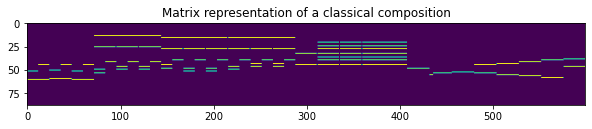

In [13]:
plt.figure(figsize=(10,7))
plt.title("Matrix representation of a classical composition")
plt.imshow(X_train[0][0].T)

# Training and Validation Routine

In [14]:
def evaluate(model,val_loader,device,loss_fn):
    model.eval()
    val_loss = 0.0
    steps = 0
    
    for batch in val_loader:
        steps += 1
        input_seq, output_seq = batch
        input_seq, output_seq = input_seq.to(device), output_seq.to(device)
        # try to fix error :"addmm_cuda" not implemented for 'Long'
        input_seq = input_seq.float()
        
        output_seq = output_seq.transpose(0,1).contiguous()
        output_seq = output_seq.contiguous().view(-1)
        
        final,_ = model(input_seq)
        # try to fix:"nll_loss_forward_reduce_cuda_kernel_2d_index" not implemented for 'Float'
        #final, output_seq = final.double(),output_seq.double()
        loss = loss_fn(final,output_seq)
        val_loss += loss.item()
    
    print("The mean validation loss is %.4f" % (val_loss/steps))
    print()
    return val_loss/steps

In [15]:
def train(model,trainloader,valloaders,ep,print_freq,loss_fun,
          optimizer,device,run,grad_clip=1.0,mname="LSTM"):
    val_loss_best = float("inf")
    
    # total number of training steps
    num_steps = ep * (len(trainloader))
    progress_bar = tqdm(range(num_steps))
    
    # calculate how often print the result
    #  if num_step = 12, and print_freq = 3, then print every 4 steps
    print_every = math.floor(num_steps/print_freq)
    
    # initialize
    steps = 0
    #model.to(device) ## error when run this twice
    model.train()
    train_losses = []
    val_losses = []
    which_val = 0
    
    for e in range(ep):
        current_loss = 0
        for batch in trainloader:
            input_s, output_s = batch
            steps += 1
            input_seq, output_seq = input_s.to(device), output_s.to(device)
            # try to fix error :"addmm_cuda" not implemented for 'Long'
            #  note: output_seq should stay long (int)
            input_seq = input_seq.float()
            #print("input shape: ",input_seq.shape)
            
            output_seq = output_seq.transpose(0,1).contiguous()
            #print("output shape: ", output_seq.shape)
            output_seq = output_seq.contiguous().view(-1)
            
            #print("output shape: ", output_seq.shape)
            #print("largest output: ", torch.max(output_seq))
            
            # calculate grad and update
            optimizer.zero_grad()
            final,_ = model(input_seq)
            #print("prediction shape: ", final.shape)
            #print("largest prediction: ", torch.max(final.permute(1,0)[0]))
            # calculate loss and record loss
            # try to fix:"nll_loss_forward_reduce_cuda_kernel_2d_index" not implemented for 'Float'
            #final, output_seq = final.double(),output_seq.double()
            loss = loss_fun(final, output_seq)
            #print("loss: ", loss)
            train_losses.append(loss.item())
            current_loss += loss.item()
            # update parameter
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(),grad_clip)
            optimizer.step()
            
            # update progress bar
            progress_bar.update(1)
            
            # print if reach the threshold we want
            if steps % print_every == 0:
                # training loss: divided by the number of steps taken during training
                #  from last print to current print
                if steps > 90:
                    print('EPOCHS : {}/{} - step - {}'.format(e+1,ep,steps),
                          'Loss : {:.6f}'.format(current_loss/print_every))
                else:
                    print('EPOCHS : {}/{} - step - {}'.format(e+1,ep,steps),
                          'Loss : {:.6f}'.format(current_loss/10))
                current_loss = 0
                #which_val = random.randint(0,4)
                which_val = random.randint(0,2) # now I only have 3 val sets
                # val loss: divided by the number of steps taken when validate
                val_loss = evaluate(model,valloaders[which_val],device,loss_fun)
                val_losses.append(val_loss)
                
                # add call back
                if val_loss < val_loss_best:
                    val_loss_best = val_loss
                    torch.save(model.state_dict(),
                     "Handcrafted Dataset - One Hot Weights/"+mname+"-run-{}-val_loss-BEST.pth".format(run))
            model.train()
    torch.save(model.state_dict(),
         "Handcrafted Dataset - One Hot Weights/ComplexLSTM_3composer-run-{}-val_loss-LAST.pth".format(run))
    return train_losses, val_losses
            
    

In [16]:
a = torch.tensor([1,1,1,0,4])
b = [i if i<=1 else 1 for i in a]
b = torch.tensor(b,dtype=torch.long)
b

tensor([1, 1, 1, 0, 1])

In [11]:
random.randint(0,4)

2

# Model: Base


###  embedding dimension: 512
###  hidden dimension: 512
###  LSTM layers: 2
###  batchnorm after embedding&LSTM
###  dropout_embed: 0.2
###  dropout_lstm: 0.2
###  grad clip: 1
### Train loss: 
###  Val loss:
###  Test loss:

In [17]:
class MusicLSTM(nn.Module):
    def __init__(self, input_size = 88, embed_size = 512, hidden_size = 512, 
                  num_class = 88, layers = 2):
        super(MusicLSTM, self).__init__()
        self.input_size = input_size
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.num_class = num_class
        self.layers = layers
        self.notes_encoder = nn.Linear(in_features=input_size, out_features=embed_size)
        self.layernorm_encoder = nn.LayerNorm(embed_size)
        self.layernorm_lstm = nn.LayerNorm(hidden_size)
        self.lstm = nn.LSTM(embed_size,hidden_size,layers)
        self.final = nn.Linear(hidden_size,num_class)
        ###
        #self.final = nn.Linear(hidden_size,128)
        #self.final2 = nn.Linear(128,num_class)
        #self.relu = nn.ReLU()
        ###
        
    def forward(self,sequences,hidden=None):
        # seq shape (batch,seq_len,88)
        notes_encoded = self.notes_encoder(sequences) # shape (batch,seq_len,embed_size)
        #notes_rolled = notes_encoded.permute(1,2,0).contiguous()
                                                      # shape (seq_len,embed_size,batch)
        notes_rolled = notes_encoded
        notes_lnormed = self.layernorm_encoder(notes_rolled)
        notes_lnormed = nn.Dropout(0.2)(notes_lnormed)
        #notes = notes_lnormed.permute(2,0,1)          # shape (batch,seq_len,embed_size)
        notes = notes_lnormed
        
        # output shape (batch,seq_len,hidden_size)
        output, hidden = self.lstm(notes,hidden)
        
        #output_lnormed = self.layernorm_lstm(output.permute(1,2,0).contiguous())
        output_lnormed = self.layernorm_lstm(output)
        output_lnormed = nn.Dropout(0.2)(output_lnormed)
        

        
        # only take the final 200
        output_lnormed = output_lnormed[:,-500:,:] 
        
        # final shape (batch,200,num_class)
        #final = self.final(output_lnormed.permute(2,0,1))
        final = self.final(output_lnormed) # final (batch,200,hidden_size) --> 
                                            #                 (batch,200,88)
        
        ###
        #final = self.relu(final)
        #final = nn.Dropout(0.5)(final)
        #final = self.final2(final)
        
        
        ###
        
        # final shape (200,batch,88)
        final = final.transpose(0,1).contiguous()
        #print("final shape: ", final.shape)
        
        # create a second measure for prediction per class, shape(seq_len,batch,num_class)
        neg_final = 1 - final
        
        # two "predictions" for each node
        zero_one_final = torch.stack((final,neg_final),dim=3).contiguous()
        
        # flatten everything except for the two predictions dimension
        flatten_final = zero_one_final.view(-1,2)
        
        return flatten_final, hidden
        
        

### run 1

In [12]:
LSTM_base = MusicLSTM(input_size=88,embed_size=512,hidden_size=512,num_class=88).cuda()

loss_fun = nn.CrossEntropyLoss()
optimizer = optim.AdamW(LSTM_base.parameters(),lr=1e-3)


In [13]:
# num_step = 1907 * ep, feq = 8, print every 190 batches
train_loss, val_loss = train(LSTM_base,train_dataloader,val_dataloaders,1,20,
      loss_fun,optimizer,'cuda',1,grad_clip=1.0)

  0%|          | 0/1907 [00:00<?, ?it/s]

EPOCHS : 1/1 - step - 10 Loss : 1.289201
The mean validation loss is 1.2395
EPOCHS : 1/1 - step - 20 Loss : 1.154012
The mean validation loss is 1.1400
EPOCHS : 1/1 - step - 30 Loss : 0.948867
The mean validation loss is 0.8806
EPOCHS : 1/1 - step - 40 Loss : 0.689564
The mean validation loss is 0.4864
EPOCHS : 1/1 - step - 50 Loss : 0.428878
The mean validation loss is 0.2484
EPOCHS : 1/1 - step - 60 Loss : 0.242519
The mean validation loss is 0.1285
EPOCHS : 1/1 - step - 70 Loss : 0.141892
The mean validation loss is 0.0786
EPOCHS : 1/1 - step - 80 Loss : 0.094775
The mean validation loss is 0.0609
EPOCHS : 1/1 - step - 90 Loss : 0.068720
The mean validation loss is 0.0572
EPOCHS : 1/1 - step - 95 Loss : 0.003011
The mean validation loss is 0.0489
EPOCHS : 1/1 - step - 190 Loss : 0.039445
The mean validation loss is 0.0328
EPOCHS : 1/1 - step - 285 Loss : 0.033110
The mean validation loss is 0.0321
EPOCHS : 1/1 - step - 380 Loss : 0.031146
The mean validation loss is 0.0304
EPOCHS : 

### Run 2

In [14]:
LSTM_base = MusicLSTM(input_size=88,embed_size=512,hidden_size=512,num_class=88).cuda()

weights_folder = "Handcrafted Dataset - One Hot Weights/"
model = "0.027"
weights = weights_folder+"LSTM_base-run-1-val_loss-"+model+ ".pth"
LSTM_base.load_state_dict(torch.load(weights))

loss_fun = nn.CrossEntropyLoss()
optimizer = optim.AdamW(LSTM_base.parameters(),lr=1e-7)

In [15]:
train_loss, val_loss = train(LSTM_base,train_dataloader,val_dataloaders,2,20,
      loss_fun,optimizer,'cuda',2,grad_clip=1.0)

  0%|          | 0/3814 [00:00<?, ?it/s]

EPOCHS : 1/2 - step - 190 Loss : 0.027261
The mean validation loss is 0.0271
EPOCHS : 1/2 - step - 380 Loss : 0.027293
The mean validation loss is 0.0271
EPOCHS : 1/2 - step - 570 Loss : 0.027260
The mean validation loss is 0.0270
EPOCHS : 1/2 - step - 760 Loss : 0.027347
The mean validation loss is 0.0270
EPOCHS : 1/2 - step - 950 Loss : 0.027211
The mean validation loss is 0.0270
EPOCHS : 1/2 - step - 1140 Loss : 0.027324
The mean validation loss is 0.0270
EPOCHS : 1/2 - step - 1330 Loss : 0.027202
The mean validation loss is 0.0270
EPOCHS : 1/2 - step - 1520 Loss : 0.027235
The mean validation loss is 0.0270
EPOCHS : 1/2 - step - 1710 Loss : 0.027222
The mean validation loss is 0.0271
EPOCHS : 1/2 - step - 1900 Loss : 0.027250
The mean validation loss is 0.0269
EPOCHS : 2/2 - step - 2090 Loss : 0.026198
The mean validation loss is 0.0270
EPOCHS : 2/2 - step - 2280 Loss : 0.027183
The mean validation loss is 0.0270
EPOCHS : 2/2 - step - 2470 Loss : 0.027269
The mean validation loss i

In [18]:
torch.save(LSTM_base.state_dict(),
 "Handcrafted Dataset - One Hot Weights/LSTM_base-run-2.pth")

# Chopin - 400 predict 200

In [35]:
LSTM_Chopin = MusicLSTM(input_size=88,embed_size=512,hidden_size=512,num_class=88).cuda()
loss_fun = nn.CrossEntropyLoss()
optimizer = optim.AdamW(LSTM_Chopin.parameters(),lr=1e-3)

In [36]:
train_loss, val_loss = train(LSTM_Chopin,train_dataloader,val_dataloaders,10,20,
      loss_fun,optimizer,'cuda',1,grad_clip=1.0,mname="LSTM_Chopin")

  0%|          | 0/990 [00:00<?, ?it/s]

EPOCHS : 1/10 - step - 49 Loss : 0.764307
The mean validation loss is 0.0773

EPOCHS : 1/10 - step - 98 Loss : 0.044465
The mean validation loss is 0.0319

EPOCHS : 2/10 - step - 147 Loss : 0.027584
The mean validation loss is 0.0263

EPOCHS : 2/10 - step - 196 Loss : 0.026742
The mean validation loss is 0.0268

EPOCHS : 3/10 - step - 245 Loss : 0.024985
The mean validation loss is 0.0257

EPOCHS : 3/10 - step - 294 Loss : 0.025467
The mean validation loss is 0.0245

EPOCHS : 4/10 - step - 343 Loss : 0.023836
The mean validation loss is 0.0248

EPOCHS : 4/10 - step - 392 Loss : 0.025040
The mean validation loss is 0.0258

EPOCHS : 5/10 - step - 441 Loss : 0.022941
The mean validation loss is 0.0254

EPOCHS : 5/10 - step - 490 Loss : 0.024680
The mean validation loss is 0.0254

EPOCHS : 6/10 - step - 539 Loss : 0.022104
The mean validation loss is 0.0254

EPOCHS : 6/10 - step - 588 Loss : 0.024408
The mean validation loss is 0.0248

EPOCHS : 7/10 - step - 637 Loss : 0.021499
The mean va

In [39]:
torch.save(LSTM_Chopin.state_dict(),
 "Handcrafted Dataset - One Hot Weights/LSTM_Chopin-run-1.pth")

In [66]:
train_loss, val_loss = train(LSTM_Chopin,train_dataloader,val_dataloaders,100,20,
      loss_fun,optimizer,'cuda',2,grad_clip=2.0,mname="LSTM_Chopin")

  0%|          | 0/9900 [00:00<?, ?it/s]

EPOCHS : 5/100 - step - 495 Loss : 0.004701
The mean validation loss is 0.0238

EPOCHS : 10/100 - step - 990 Loss : 0.004657
The mean validation loss is 0.0238

EPOCHS : 15/100 - step - 1485 Loss : 0.004598
The mean validation loss is 0.0243

EPOCHS : 20/100 - step - 1980 Loss : 0.004568
The mean validation loss is 0.0231

EPOCHS : 25/100 - step - 2475 Loss : 0.004547
The mean validation loss is 0.0241

EPOCHS : 30/100 - step - 2970 Loss : 0.004515
The mean validation loss is 0.0232

EPOCHS : 35/100 - step - 3465 Loss : 0.004484
The mean validation loss is 0.0234

EPOCHS : 40/100 - step - 3960 Loss : 0.004458
The mean validation loss is 0.0236

EPOCHS : 45/100 - step - 4455 Loss : 0.004445
The mean validation loss is 0.0237

EPOCHS : 50/100 - step - 4950 Loss : 0.004418
The mean validation loss is 0.0234

EPOCHS : 55/100 - step - 5445 Loss : 0.004396
The mean validation loss is 0.0234

EPOCHS : 60/100 - step - 5940 Loss : 0.004378
The mean validation loss is 0.0227

EPOCHS : 65/100 - s

In [68]:
torch.save(LSTM_Chopin.state_dict(),
 "Handcrafted Dataset - One Hot Weights/LSTM_Chopin-run-2-val_loss_LAST.pth")

# Chopin predict whole song

In [89]:
LSTM_Chopin = MusicLSTM(input_size=88,embed_size=512,hidden_size=512,num_class=88).cuda()
loss_fun = nn.CrossEntropyLoss()
optimizer = optim.AdamW(LSTM_Chopin.parameters(),lr=1e-3)

In [90]:
train_loss, val_loss = train(LSTM_Chopin,train_dataloader,val_dataloaders,10,40,
      loss_fun,optimizer,'cuda',1,grad_clip=2.0,mname="LSTM_Chopin2")

  0%|          | 0/990 [00:00<?, ?it/s]

EPOCHS : 1/10 - step - 24 Loss : 0.487422
The mean validation loss is 0.1303

EPOCHS : 1/10 - step - 48 Loss : 0.294884
The mean validation loss is 0.1060

EPOCHS : 1/10 - step - 72 Loss : 0.196855
The mean validation loss is 0.0548

EPOCHS : 1/10 - step - 96 Loss : 0.043571
The mean validation loss is 0.0354

EPOCHS : 2/10 - step - 120 Loss : 0.028337
The mean validation loss is 0.0296

EPOCHS : 2/10 - step - 144 Loss : 0.029392
The mean validation loss is 0.0275

EPOCHS : 2/10 - step - 168 Loss : 0.027438
The mean validation loss is 0.0274

EPOCHS : 2/10 - step - 192 Loss : 0.026904
The mean validation loss is 0.0273

EPOCHS : 3/10 - step - 216 Loss : 0.019861
The mean validation loss is 0.0267

EPOCHS : 3/10 - step - 240 Loss : 0.026696
The mean validation loss is 0.0263

EPOCHS : 3/10 - step - 264 Loss : 0.025958
The mean validation loss is 0.0264

EPOCHS : 3/10 - step - 288 Loss : 0.026071
The mean validation loss is 0.0263

EPOCHS : 4/10 - step - 312 Loss : 0.016045
The mean vali

In [91]:
torch.save(LSTM_Chopin.state_dict(),
 "Handcrafted Dataset - One Hot Weights/LSTM_Chopin2-run-1-val_loss-LAST.pth")

# Chopin3 loss: final 500

In [13]:
LSTM_Chopin3 = MusicLSTM(input_size=88,embed_size=512,hidden_size=512,num_class=88).cuda()
loss_fun = nn.CrossEntropyLoss()
optimizer = optim.AdamW(LSTM_Chopin3.parameters(),lr=1e-3)

In [14]:
train_loss, val_loss = train(LSTM_Chopin3,train_dataloader,val_dataloaders,50,80,
      loss_fun,optimizer,'cuda',1,grad_clip=2.0,mname="LSTM_Chopin3")

  0%|          | 0/7150 [00:00<?, ?it/s]

EPOCHS : 1/50 - step - 89 Loss : 1.105215
The mean validation loss is 0.0429

EPOCHS : 2/50 - step - 178 Loss : 0.011125
The mean validation loss is 0.0277

EPOCHS : 2/50 - step - 267 Loss : 0.027000
The mean validation loss is 0.0272

EPOCHS : 3/50 - step - 356 Loss : 0.020514
The mean validation loss is 0.0259

EPOCHS : 4/50 - step - 445 Loss : 0.004637
The mean validation loss is 0.0263

EPOCHS : 4/50 - step - 534 Loss : 0.025554
The mean validation loss is 0.0252

EPOCHS : 5/50 - step - 623 Loss : 0.014485
The mean validation loss is 0.0254

EPOCHS : 5/50 - step - 712 Loss : 0.024900
The mean validation loss is 0.0248

EPOCHS : 6/50 - step - 801 Loss : 0.023782
The mean validation loss is 0.0245

EPOCHS : 7/50 - step - 890 Loss : 0.008840
The mean validation loss is 0.0244

EPOCHS : 7/50 - step - 979 Loss : 0.024549
The mean validation loss is 0.0242

EPOCHS : 8/50 - step - 1068 Loss : 0.018224
The mean validation loss is 0.0242

EPOCHS : 9/50 - step - 1157 Loss : 0.003505
The mean

In [16]:
torch.save(LSTM_Chopin3.state_dict(),
 "Handcrafted Dataset - One Hot Weights/LSTM_Chopin3-run-1-val_loss-LAST.pth")

In [31]:
LSTM_Chopin3 = MusicLSTM(input_size=88,embed_size=512,hidden_size=512,num_class=88).cuda()
LSTM_Chopin3.load_state_dict(torch.load("Handcrafted Dataset - One Hot Weights/LSTM_Chopin3-run-1-val_loss-LAST.pth"))

<All keys matched successfully>

In [32]:
train_loss, val_loss = train(LSTM_Chopin3,train_dataloader,val_dataloaders,50,80,
      loss_fun,optimizer,'cuda',2,grad_clip=3.0,mname="LSTM_Chopin3")

  0%|          | 0/7150 [00:00<?, ?it/s]

EPOCHS : 1/50 - step - 89 Loss : 0.193799
The mean validation loss is 0.0224

EPOCHS : 2/50 - step - 178 Loss : 0.008614
The mean validation loss is 0.0223

EPOCHS : 2/50 - step - 267 Loss : 0.021991
The mean validation loss is 0.0222

EPOCHS : 3/50 - step - 356 Loss : 0.017111
The mean validation loss is 0.0222

EPOCHS : 4/50 - step - 445 Loss : 0.003999
The mean validation loss is 0.0222

EPOCHS : 4/50 - step - 534 Loss : 0.021925
The mean validation loss is 0.0227

EPOCHS : 5/50 - step - 623 Loss : 0.012526
The mean validation loss is 0.0228

EPOCHS : 5/50 - step - 712 Loss : 0.021938
The mean validation loss is 0.0227

EPOCHS : 6/50 - step - 801 Loss : 0.021075
The mean validation loss is 0.0227

EPOCHS : 7/50 - step - 890 Loss : 0.008070
The mean validation loss is 0.0223

EPOCHS : 7/50 - step - 979 Loss : 0.021909
The mean validation loss is 0.0228

EPOCHS : 8/50 - step - 1068 Loss : 0.016500
The mean validation loss is 0.0222

EPOCHS : 9/50 - step - 1157 Loss : 0.003137
The mean

In [33]:
torch.save(LSTM_Chopin3.state_dict(),
 "Handcrafted Dataset - One Hot Weights/LSTM_Chopin3-run-2-val_loss-LAST.pth")

In [40]:
train_loss, val_loss = train(LSTM_Chopin3,train_dataloader,val_dataloaders,50,50,
      loss_fun,optimizer,'cuda',3,grad_clip=3.0,mname="LSTM_Chopin3")

  0%|          | 0/7150 [00:00<?, ?it/s]

EPOCHS : 1/50 - step - 143 Loss : 0.021927
The mean validation loss is 0.0222

EPOCHS : 2/50 - step - 286 Loss : 0.021906
The mean validation loss is 0.0228

EPOCHS : 3/50 - step - 429 Loss : 0.021935
The mean validation loss is 0.0227

EPOCHS : 4/50 - step - 572 Loss : 0.021942
The mean validation loss is 0.0223

EPOCHS : 5/50 - step - 715 Loss : 0.021931
The mean validation loss is 0.0226

EPOCHS : 6/50 - step - 858 Loss : 0.021949
The mean validation loss is 0.0223

EPOCHS : 7/50 - step - 1001 Loss : 0.021966
The mean validation loss is 0.0221

EPOCHS : 8/50 - step - 1144 Loss : 0.021923
The mean validation loss is 0.0222

EPOCHS : 9/50 - step - 1287 Loss : 0.021910
The mean validation loss is 0.0223

EPOCHS : 10/50 - step - 1430 Loss : 0.021955
The mean validation loss is 0.0223

EPOCHS : 11/50 - step - 1573 Loss : 0.021911
The mean validation loss is 0.0227

EPOCHS : 12/50 - step - 1716 Loss : 0.021946
The mean validation loss is 0.0221

EPOCHS : 13/50 - step - 1859 Loss : 0.02195

In [41]:
torch.save(LSTM_Chopin3.state_dict(),
 "Handcrafted Dataset - One Hot Weights/LSTM_Chopin3-run-3-val_loss-LAST.pth")

# chopin3 with 3 composers - base model - 0.213

In [12]:
LSTM_Chopin3 = MusicLSTM(input_size=88,embed_size=512,hidden_size=512,num_class=88).cuda()
LSTM_Chopin3.load_state_dict(torch.load("Handcrafted Dataset - One Hot Weights/LSTM_Chopin3-run-2-val_loss-LAST.pth"))

loss_fun = nn.CrossEntropyLoss()
optimizer = optim.AdamW(LSTM_Chopin3.parameters(),lr=1e-5)

In [13]:
train_loss, val_loss = train(LSTM_Chopin3,train_dataloader,val_dataloaders,15,30,
      loss_fun,optimizer,'cuda',4,grad_clip=1.0,mname="LSTM_Chopin3composer")

  0%|          | 0/10065 [00:00<?, ?it/s]

EPOCHS : 1/15 - step - 335 Loss : 0.022518
The mean validation loss is 0.0222

EPOCHS : 1/15 - step - 670 Loss : 0.022031
The mean validation loss is 0.0220

EPOCHS : 2/15 - step - 1005 Loss : 0.021838
The mean validation loss is 0.0219

EPOCHS : 2/15 - step - 1340 Loss : 0.021896
The mean validation loss is 0.0219

EPOCHS : 3/15 - step - 1675 Loss : 0.021590
The mean validation loss is 0.0217

EPOCHS : 3/15 - step - 2010 Loss : 0.021816
The mean validation loss is 0.0217

EPOCHS : 4/15 - step - 2345 Loss : 0.021542
The mean validation loss is 0.0216

EPOCHS : 4/15 - step - 2680 Loss : 0.021635
The mean validation loss is 0.0216

EPOCHS : 5/15 - step - 3015 Loss : 0.021382
The mean validation loss is 0.0216

EPOCHS : 5/15 - step - 3350 Loss : 0.021601
The mean validation loss is 0.0217

EPOCHS : 6/15 - step - 3685 Loss : 0.021267
The mean validation loss is 0.0216

EPOCHS : 6/15 - step - 4020 Loss : 0.021549
The mean validation loss is 0.0216

EPOCHS : 7/15 - step - 4355 Loss : 0.02117

In [14]:
optimizer = optim.AdamW(LSTM_Chopin3.parameters(),lr=1e-6)
train_loss, val_loss = train(LSTM_Chopin3,train_dataloader,val_dataloaders,10,20,
      loss_fun,optimizer,'cuda',5,grad_clip=1.0,mname="LSTM_Chopin3composer")

  0%|          | 0/6710 [00:00<?, ?it/s]

EPOCHS : 1/10 - step - 335 Loss : 0.021371
The mean validation loss is 0.0213

EPOCHS : 1/10 - step - 670 Loss : 0.021312
The mean validation loss is 0.0213

EPOCHS : 2/10 - step - 1005 Loss : 0.021289
The mean validation loss is 0.0213

EPOCHS : 2/10 - step - 1340 Loss : 0.021320
The mean validation loss is 0.0213

EPOCHS : 3/10 - step - 1675 Loss : 0.021185
The mean validation loss is 0.0213

EPOCHS : 3/10 - step - 2010 Loss : 0.021350
The mean validation loss is 0.0213

EPOCHS : 4/10 - step - 2345 Loss : 0.021202
The mean validation loss is 0.0213

EPOCHS : 4/10 - step - 2680 Loss : 0.021282
The mean validation loss is 0.0213

EPOCHS : 5/10 - step - 3015 Loss : 0.021047
The mean validation loss is 0.0213

EPOCHS : 5/10 - step - 3350 Loss : 0.021359
The mean validation loss is 0.0213

EPOCHS : 6/10 - step - 3685 Loss : 0.021146
The mean validation loss is 0.0213

EPOCHS : 6/10 - step - 4020 Loss : 0.021196
The mean validation loss is 0.0213

EPOCHS : 7/10 - step - 4355 Loss : 0.02088

# Mozart 

## base - run 1

In [14]:
LSTM_Mozart = MusicLSTM(input_size=88,embed_size=512,hidden_size=512,num_class=88).cuda()
weights = torch.cuda.FloatTensor([1.0,3.0])
loss_fun = nn.CrossEntropyLoss(weights)
optimizer = optim.AdamW(LSTM_Mozart.parameters(),lr=1e-3)

In [15]:
train_loss, val_loss = train(LSTM_Mozart,train_dataloader,val_dataloaders,20,60,
      loss_fun,optimizer,'cuda',1,grad_clip=2.0,mname="LSTM_Mozart")

  0%|          | 0/2520 [00:00<?, ?it/s]

EPOCHS : 1/20 - step - 42 Loss : 0.883349
The mean validation loss is 0.0983

EPOCHS : 1/20 - step - 84 Loss : 0.247877
The mean validation loss is 0.0442

EPOCHS : 1/20 - step - 126 Loss : 0.042777
The mean validation loss is 0.0415

EPOCHS : 2/20 - step - 168 Loss : 0.041500
The mean validation loss is 0.0401

EPOCHS : 2/20 - step - 210 Loss : 0.040480
The mean validation loss is 0.0395

EPOCHS : 2/20 - step - 252 Loss : 0.039783
The mean validation loss is 0.0390

EPOCHS : 3/20 - step - 294 Loss : 0.039540
The mean validation loss is 0.0396

EPOCHS : 3/20 - step - 336 Loss : 0.039631
The mean validation loss is 0.0394

EPOCHS : 3/20 - step - 378 Loss : 0.038877
The mean validation loss is 0.0383

EPOCHS : 4/20 - step - 420 Loss : 0.039232
The mean validation loss is 0.0384

EPOCHS : 4/20 - step - 462 Loss : 0.038302
The mean validation loss is 0.0381

EPOCHS : 4/20 - step - 504 Loss : 0.038274
The mean validation loss is 0.0384

EPOCHS : 5/20 - step - 546 Loss : 0.038339
The mean va

In [16]:
torch.save(LSTM_Mozart.state_dict(),
 "Handcrafted Dataset - One Hot Weights/LSTM_Mozart-run-1-val_loss-LAST.pth")

In [42]:
train_loss, val_loss = train(LSTM_Mozart,train_dataloader,val_dataloaders,20,60,
      loss_fun,optimizer,'cuda',2,grad_clip=2.0,mname="LSTM_Mozart")

  0%|          | 0/2520 [00:00<?, ?it/s]

EPOCHS : 1/20 - step - 42 Loss : 0.152289
The mean validation loss is 0.0361

EPOCHS : 1/20 - step - 84 Loss : 0.151962
The mean validation loss is 0.0357

EPOCHS : 1/20 - step - 126 Loss : 0.036097
The mean validation loss is 0.0357

EPOCHS : 2/20 - step - 168 Loss : 0.036163
The mean validation loss is 0.0358

EPOCHS : 2/20 - step - 210 Loss : 0.035818
The mean validation loss is 0.0358

EPOCHS : 2/20 - step - 252 Loss : 0.036171
The mean validation loss is 0.0358

EPOCHS : 3/20 - step - 294 Loss : 0.036019
The mean validation loss is 0.0364

EPOCHS : 3/20 - step - 336 Loss : 0.035975
The mean validation loss is 0.0358

EPOCHS : 3/20 - step - 378 Loss : 0.035936
The mean validation loss is 0.0354

EPOCHS : 4/20 - step - 420 Loss : 0.036149
The mean validation loss is 0.0358

EPOCHS : 4/20 - step - 462 Loss : 0.035953
The mean validation loss is 0.0361

EPOCHS : 4/20 - step - 504 Loss : 0.035743
The mean validation loss is 0.0364

EPOCHS : 5/20 - step - 546 Loss : 0.035736
The mean va

In [43]:
torch.save(LSTM_Mozart.state_dict(),
 "Handcrafted Dataset - One Hot Weights/LSTM_Mozart-run-2-val_loss-LAST.pth")

# one song - waldstein

In [11]:
LSTM_wald = MusicLSTM(input_size=88,embed_size=512,hidden_size=512,num_class=88).cuda()
weights = torch.cuda.FloatTensor([1.0,3.0])
loss_fun = nn.CrossEntropyLoss(weights)
optimizer = optim.AdamW(LSTM_wald.parameters(),lr=5e-3)

In [12]:
train_loss, val_loss = train(LSTM_wald,train_dataloader,val_dataloaders,10,20,
      loss_fun,optimizer,'cuda',1,grad_clip=2.0,mname="LSTM_wald")

  0%|          | 0/2580 [00:00<?, ?it/s]

EPOCHS : 1/10 - step - 129 Loss : 0.193240
The mean validation loss is 0.1020

EPOCHS : 1/10 - step - 258 Loss : 0.071592
The mean validation loss is 0.0548

EPOCHS : 2/10 - step - 387 Loss : 0.048751
The mean validation loss is 0.0449

EPOCHS : 2/10 - step - 516 Loss : 0.042844
The mean validation loss is 0.0417

EPOCHS : 3/10 - step - 645 Loss : 0.040303
The mean validation loss is 0.0396

EPOCHS : 3/10 - step - 774 Loss : 0.038814
The mean validation loss is 0.0387

EPOCHS : 4/10 - step - 903 Loss : 0.037712
The mean validation loss is 0.0372

EPOCHS : 4/10 - step - 1032 Loss : 0.036958
The mean validation loss is 0.0372

EPOCHS : 5/10 - step - 1161 Loss : 0.036394
The mean validation loss is 0.0361

EPOCHS : 5/10 - step - 1290 Loss : 0.035648
The mean validation loss is 0.0356

EPOCHS : 6/10 - step - 1419 Loss : 0.035330
The mean validation loss is 0.0349

EPOCHS : 6/10 - step - 1548 Loss : 0.034907
The mean validation loss is 0.0349

EPOCHS : 7/10 - step - 1677 Loss : 0.034596
The

In [13]:
torch.save(LSTM_wald.state_dict(),
 "Handcrafted Dataset - One Hot Weights/LSTM_wald-run-1-val_loss-LAST.pth")

In [14]:
train_loss, val_loss = train(LSTM_wald,train_dataloader,val_dataloaders,10,20,
      loss_fun,optimizer,'cuda',2,grad_clip=2.0,mname="LSTM_wald")

  0%|          | 0/2580 [00:00<?, ?it/s]

EPOCHS : 1/10 - step - 129 Loss : 0.032910
The mean validation loss is 0.0327

EPOCHS : 1/10 - step - 258 Loss : 0.032703
The mean validation loss is 0.0327

EPOCHS : 2/10 - step - 387 Loss : 0.032636
The mean validation loss is 0.0325

EPOCHS : 2/10 - step - 516 Loss : 0.032496
The mean validation loss is 0.0325

EPOCHS : 3/10 - step - 645 Loss : 0.032548
The mean validation loss is 0.0323

EPOCHS : 3/10 - step - 774 Loss : 0.032261
The mean validation loss is 0.0328

EPOCHS : 4/10 - step - 903 Loss : 0.032323
The mean validation loss is 0.0322

EPOCHS : 4/10 - step - 1032 Loss : 0.032283
The mean validation loss is 0.0324

EPOCHS : 5/10 - step - 1161 Loss : 0.032238
The mean validation loss is 0.0326

EPOCHS : 5/10 - step - 1290 Loss : 0.032218
The mean validation loss is 0.0326

EPOCHS : 6/10 - step - 1419 Loss : 0.032175
The mean validation loss is 0.0322

EPOCHS : 6/10 - step - 1548 Loss : 0.032094
The mean validation loss is 0.0322

EPOCHS : 7/10 - step - 1677 Loss : 0.032058
The

In [15]:
torch.save(LSTM_wald.state_dict(),
 "Handcrafted Dataset - One Hot Weights/LSTM_wald-run-2-val_loss-LAST.pth")

# Generate Music

In [21]:
# define a function to extract hidden state given the beginning of a piece of music
#  it should start from time step 0, extract the piano roll, take the first portion 
#   to generate hidden space and last prediction from the model
def get_hidden(model, path,len_input_seq=200,ln=200,tmp=1,start_position=0):
    # extract piano roll from the music and form one hot encoding
    multitrack = pypianoroll.read(path)
    multitrack.binarize()
    combined_track = multitrack.blend()
    # shrink the pitches and extract the part that we need
    track_len = len(combined_track[:,0]) 
    # if track_len is less than the track they want
    if (track_len < len_input_seq + start_position):
        if (track_len < len_input_seq):
            input_seq = combined_track[:,21:109] # take the entire trach
        else:
            input_seq = combined_track[start_position:,21:109] 
    else:
        end_position = start_position + len_input_seq - 1
        input_seq = combined_track[start_position:end_position,21:109]
    
    # input sequence must be a tensor
    input_seq = torch.tensor(input_seq,dtype=torch.float)
    
    # model is in GPU
    
    # add batch dimension
    input_seq = torch.unsqueeze(input_seq,0)
    
    op, hidden = model(input_seq) # note hidden state don't stack
    
    # only take the last observations of each
    output = op[-88:]
    probs = nn.functional.softmax(output.div(tmp), dim=1)
    output = torch.multinomial(probs.data, 1).squeeze().unsqueeze(0).unsqueeze(1)
    output = output.float()
    
    #print(type(hidden))
    #print(type(hidden[0]))
    #print(type(hidden[0][0]))
    #print(type(hidden[0][0][0]))
    #print()

    
    # hidden size (2,2,200,512), should go with (2,2,1,512)
    h,c = hidden
    h = h[:,-1:,:]
    c = c[:,-1:,:]
    #print(h.shape)
    
    hidden = (h,c)
    

    return generate_music(model,output,hidden,ln,tmp)
    

In [22]:
# define a function to extract hidden state given the beginning of a piece of music
#  it should start from time step 0, extract the piano roll, take the first portion 
#   to generate hidden space and last prediction from the model
def get_hidden2(model, path,len_input_seq=200,ln=200,tmp=1):
    # extract piano roll from the music and form one hot encoding
    multitrack = pypianoroll.read(path)
    multitrack.binarize()
    combined_track = multitrack.blend()
    # shrink the pitches and extract the part that we need
    input_seq = combined_track[:len_input_seq,21:109]
    
    # input sequence must be a tensor
    input_seq = torch.tensor(input_seq,dtype=torch.float)
    
    # model is in GPU
    
    # add batch dimension
    input_seq = torch.unsqueeze(input_seq,0)
    
    #encode
    input_seq_encode = model.notes_encoder(input_seq)
    
    op, hidden = model.lstm(input_seq_encode) # op(1,input_seq_len,hidden_size)
    
    # apply final dense layer
    op = model.final(op) # op (1, input_seq_len, 88)
    
    final = op.transpose(0,1).contiguous()
    
    # create a second measure for prediction per class, shape(seq_len,batch,num_class)
    neg_final = 1 - final
    
    # two "predictions" for each node
    zero_one_final = torch.stack((final,neg_final),dim=3).contiguous()
    
    # flatten everything except for the two predictions dimension
    flatten_final = zero_one_final.view(-1,2) 
    
    # only take the last observations of each
    output = flatten_final[-88:]
    probs = nn.functional.softmax(output.div(tmp), dim=1)
    output = torch.multinomial(probs.data, 1).squeeze().unsqueeze(0).unsqueeze(1)
    output = output.float()
    
    #print(type(hidden))
    #print(type(hidden[0]))
    #print(type(hidden[0][0]))
    #print(type(hidden[0][0][0]))
    #print()

    
    # hidden size (2,2,200,512), should go with (2,2,1,512)
    h,c = hidden
    h = h[:,-1:,:]
    c = c[:,-1:,:]
    #print(h.shape)
    
    hidden = (h,c)
    

    return generate_music(model,output,hidden,ln,tmp)
    

In [23]:
# define a function to generate music based on the hidden state of the music
def generate_music(model, start, hidden, ln=200, tmp=1):
    seq_ip_cur = start
        
    op_seq = [seq_ip_cur.data.squeeze(1)]
    hd = hidden

    for i in range(ln):

        # input sequence is predicted outputs
        op, hd = model(seq_ip_cur, hd) # output is a vector of 88
        
        probs = nn.functional.softmax(op.div(tmp), dim=1)
        
        # update current sequence to the previous prediction
        seq_ip_cur = torch.multinomial(probs.data, 1).squeeze().unsqueeze(0).unsqueeze(1)

        # the model accept input as tensor of floats
        seq_ip_cur = seq_ip_cur.float()

        # append outputs
        op_seq.append(seq_ip_cur.data.squeeze(1))

    gen_seq = torch.cat(op_seq, dim=0).cpu().numpy()
    
    return gen_seq

In [24]:
# define a function to generate music based on the hidden state of the music
def generate_music2(model, start, hidden, ln=200, tmp=1):
    seq_ip_cur = start
        
    op_seq = [seq_ip_cur.data.squeeze(1)]
    hd = hidden

    for i in range(ln):

        # input sequence is predicted outputs
        #encode
        input_seq_encode = model.notes_encoder(seq_ip_cur)
    
        op, hd = model.lstm(input_seq_encode,hidden) # op(1,input_seq_len,hidden_size)
    
        # apply final dense layer
        op = model.final(op) # op (1, input_seq_len, 88)
        
        final = op.transpose(0,1).contiguous()
        # create a second measure for prediction per class, shape(seq_len,batch,num_class)
        neg_final = 1 - final
        # two "predictions" for each node
        zero_one_final = torch.stack((final,neg_final),dim=3).contiguous()
        # flatten everything except for the two predictions dimension
        flatten_final = zero_one_final.view(-1,2) 
        
        probs = nn.functional.softmax(flatten_final.div(tmp), dim=1)
        
        # update current sequence to the previous prediction
        seq_ip_cur = torch.multinomial(probs.data, 1).squeeze().unsqueeze(0).unsqueeze(1)

        # the model accept input as tensor of floats
        seq_ip_cur = seq_ip_cur.float()

        # append outputs
        op_seq.append(seq_ip_cur.data.squeeze(1))

    gen_seq = torch.cat(op_seq, dim=0).cpu().numpy()
    
    return gen_seq

In [33]:
def generate_sample(model,model_val,run,musicname="mz_330_1.mid",len_input_seq=200,
                    ln=200,tmp=1,model_name="LSTM_Chopin",start_position=0):
    weights_folder = "Handcrafted Dataset - One Hot Weights/old weights"
    
    # this is for simple version
    #LSTM = model(input_size=88,embed_size=512,hidden_size=512,num_class=88).cpu() 
    
    LSTM = model(88,512,512,88,2).cpu() 
    weights = model_name+"-run-"+str(run)+"-val_loss-"+model_val+ ".pth"
    weights_path = os.path.join(weights_folder,weights)
    LSTM.load_state_dict(torch.load(weights_path))
    

    musicpath = "Handcrafted Dataset - Generated Music/input/Classical/" + musicname
    LSTM.eval()
    seq = get_hidden(LSTM,musicpath,len_input_seq,ln,tmp,start_position)
    
    plt.figure(figsize=(10,7))
    plt.imshow(seq.T)
    
    outputpath = 'Handcrafted Dataset - Generated Music/'+model_name+'/run'+str(run)+'-'+model_val+'-'+musicname
    return seq, outputpath

# Experiment - LSTM_Chopin3composer - Original


In [34]:
model = MusicLSTM
model_val = "BEST"
run = 4

Handcrafted Dataset - Generated Music/LSTM_Chopin3composer/run4-BEST-mz_330_1.mid


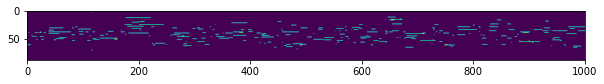

In [36]:
seq,path=generate_sample(model,model_val,run,musicname="mz_330_1.mid",len_input_seq=2000,
                    ln=1000,tmp=1.,model_name="LSTM_Chopin3composer",start_position=0)
print(path)
F.midiwrite(path, seq, dtm=0.1)

In [37]:
F.midiwrite(path, seq, dtm=0.08)

In [ ]:
chpn_op25_e1.mid
liz_et3.mid

In [47]:
print(path)

Handcrafted Dataset - Generated Music/LSTM_Chopin3composer/run4-BEST-liz_et3.mid
